In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [39]:
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/harshita_07/emotion_dataset.zip"
!unzip -q -o "emotion_dataset.zip" -d "emotion_dataset"
!rm "emotion_dataset.zip"

--2020-09-28 05:29:58--  https://cainvas-static.s3.amazonaws.com/media/user_data/harshita_07/emotion_dataset.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.64.80
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.64.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62606106 (60M) [application/x-zip-compressed]
Saving to: ‘emotion_dataset.zip’

emotion_dataset.zip 100%[===================>]  59.71M   103MB/s    in 0.6s    

2020-09-28 05:29:58 (103 MB/s) - ‘emotion_dataset.zip’ saved [62606106/62606106]



In [2]:
path = "emotion_dataset/images/"
picture_size = 48

Training Data Visualization

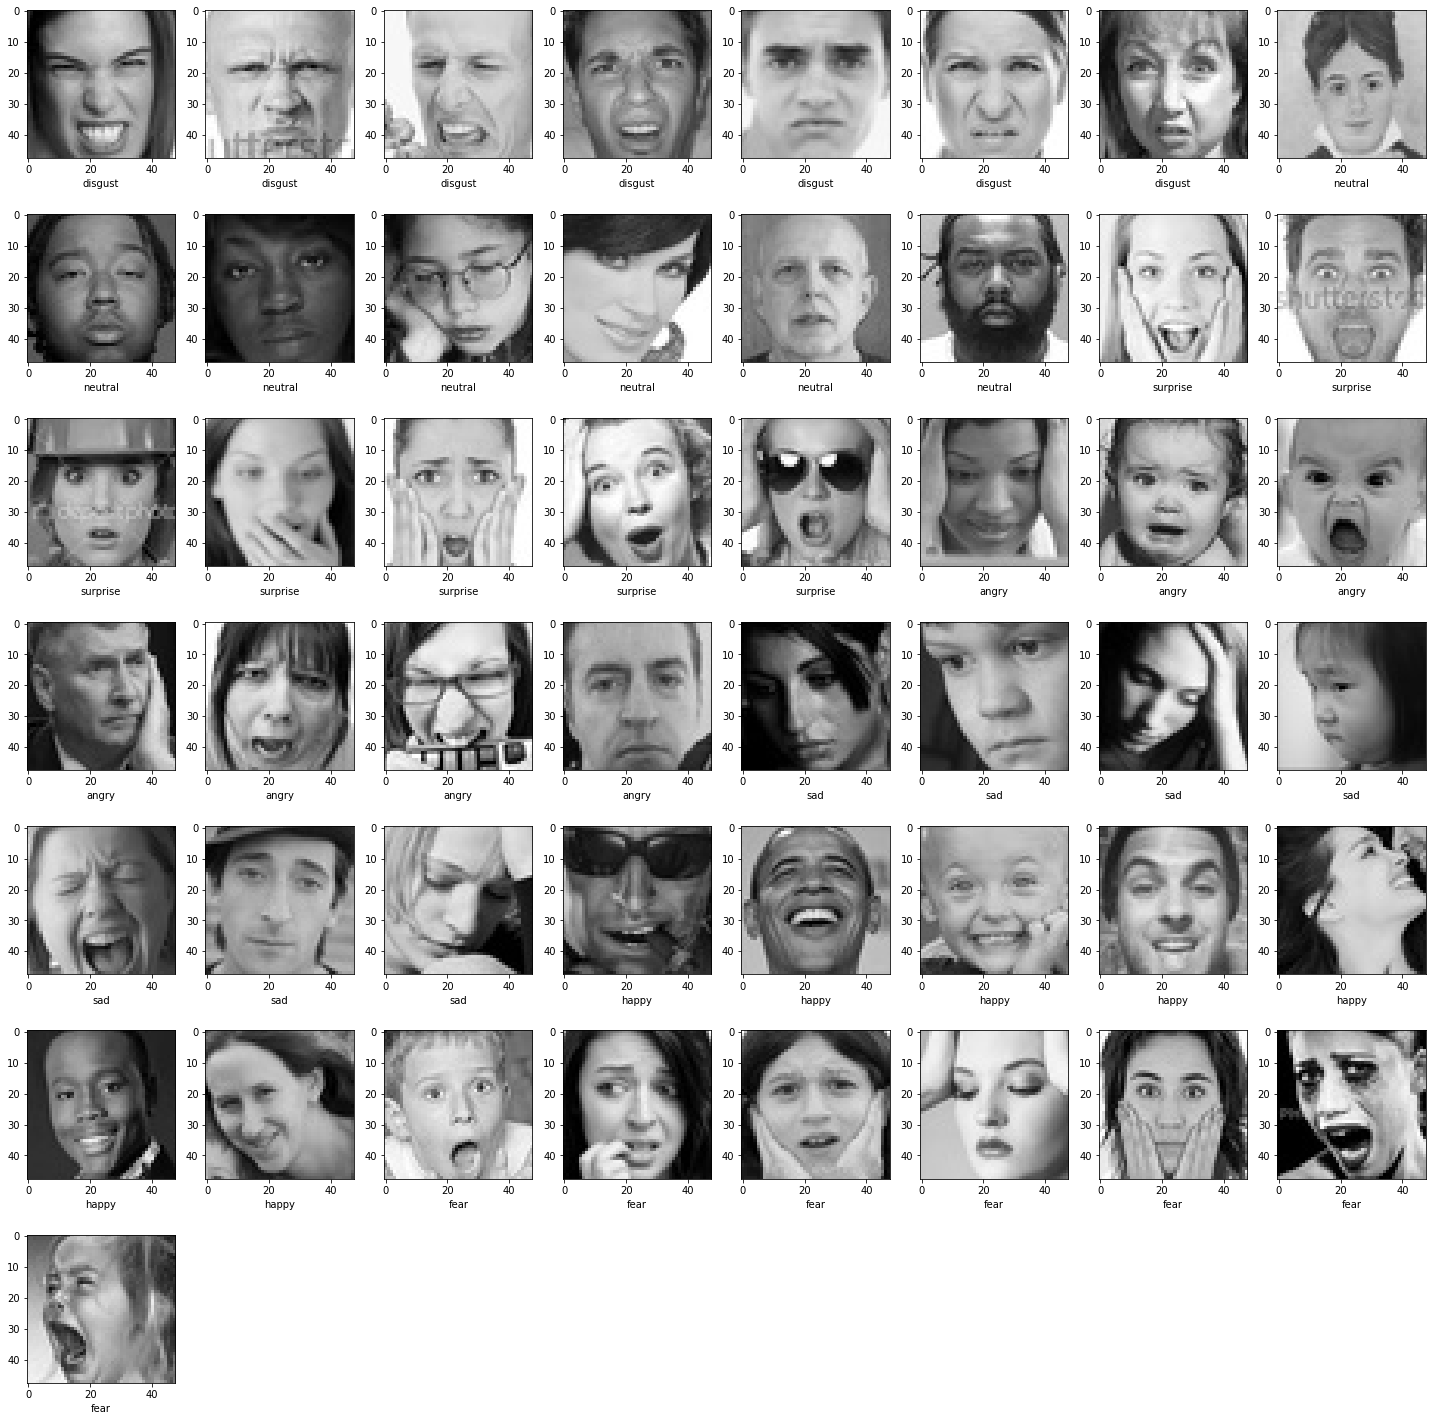

In [3]:
plt.figure(0, figsize = (20,20))
cpt = 0

for expression in os.listdir(path + "train/"):
    for i in range(0,7):
        cpt += 1
        plt.subplot(7, 8, cpt)
        img = load_img(path + "train/" + expression + "/" + os.listdir(path + "train/" + expression)[i], target_size = (picture_size, picture_size))
        plt.imshow(img, cmap = "gray")
        plt.xlabel(expression)
        
plt.tight_layout()
plt.show()

In [4]:
count = []

for expression in os.listdir(path + "train/"):
    print(str(len(os.listdir(path + "train/" + expression))) + " " + expression + " images")
    count.append(len(os.listdir(path + "train/" + expression)))

436 disgust images
4982 neutral images
3205 surprise images
3993 angry images
4938 sad images
7164 happy images
4103 fear images


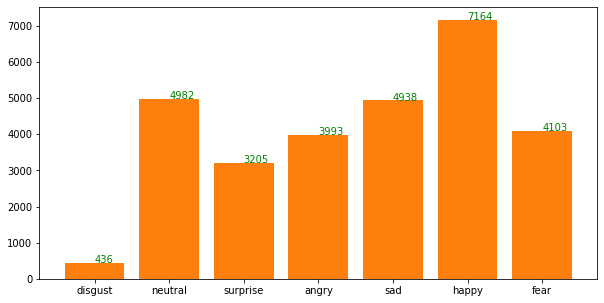

In [6]:
idx = [1, 2, 3, 4, 5, 6, 7]
plt.figure(figsize = (10,5))
plt.xticks(idx, ['disgust', 'neutral', 'surprise', 'angry', 'sad', 'happy', 'fear'])
plt.bar(idx, count)
plt.bar(idx, count)
for a,b in zip(idx, count):
    plt.text(a, b, str(b), color = 'green')

Data Augmentation

In [7]:
batch_size = 128

datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

train_generator = datagen_train.flow_from_directory(path + "train",
                                                    target_size = (picture_size, picture_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

validation_generator = datagen_validation.flow_from_directory(path + "validation",
                                                    target_size = (picture_size, picture_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical',
                                                    shuffle = False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


Model Definition

In [8]:
num_classes = 7

model = Sequential()

#1st CNN Layer
model.add(Conv2D(64, (3,3), padding = 'same', input_shape = (48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN Layer
model.add(Conv2D(128, (5,5), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#3rd CNN Layer
model.add(Conv2D(512, (3,3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#4th CNN Layer
model.add(Conv2D(512, (3,3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#Flattening
model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


model.add(Dense(num_classes, activation = 'softmax'))


model.compile(optimizer = Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

Model Training

In [9]:
num_epochs = 30

checkpoint = ModelCheckpoint("model_weights.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True,
                            mode = 'max')

callback_list = [checkpoint]

history = model.fit_generator(generator = train_generator, 
                             steps_per_epoch = train_generator.n // train_generator.batch_size,
                             epochs = num_epochs, validation_data = validation_generator,
                             validation_steps = validation_generator.n // validation_generator.batch_size,
                             callbacks = callback_list)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
225/225 [==============================] - ETA: 0s - loss: 2.0282 - accuracy: 0.2324
Epoch 00001: val_accuracy improved from -inf to 0.31349, saving model to model_weights.h5
225/225 [==============================] - 634s 3s/step - loss: 2.0282 - accuracy: 0.2324 - val_loss: 1.7292 - val_accuracy: 0.3135
Epoch 2/30
225/225 [==============================] - ETA: 0s - loss: 1.8388 - accuracy: 0.2876
Epoch 00002: val_accuracy did not improve from 0.31349
225/225 [==============================] - 611s 3s/step - loss: 1.8388 - accuracy: 0.2876 - val_loss: 1.7405 - val_accuracy: 0.3134
Epoch 3/30
225/225 [==============================] - ETA: 0s - loss: 1.7270 - accuracy: 0.3365
Epoch 00003: val_accuracy improved from 0.31349 to 0.33381, saving model to model_weights.h5
225/225 [==============================] - 616s 3s/step - loss: 1.7270 - accuracy: 0.3365 - val_loss: 1.8950 - val_accuracy: 0.3338
Ep

Result Analysis

In [12]:
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize = (24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    return
 

def get_best_epoch(history):
    validation_acc = history.history['val_accuracy']
    training_acc = history.history['accuracy']
    best_val_epoch = validation_acc.index(max(validation_acc)) + 1
    best_val_acc =  max(validation_acc)
    best_train_epoch = training_acc.index(max(training_acc)) + 1
    best_train_acc = max(training_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_val_acc, best_val_epoch))
    print('Best Training Accuracy Score {:0.5f}, is for epoch {}'.format( best_train_acc, best_train_epoch))

    return

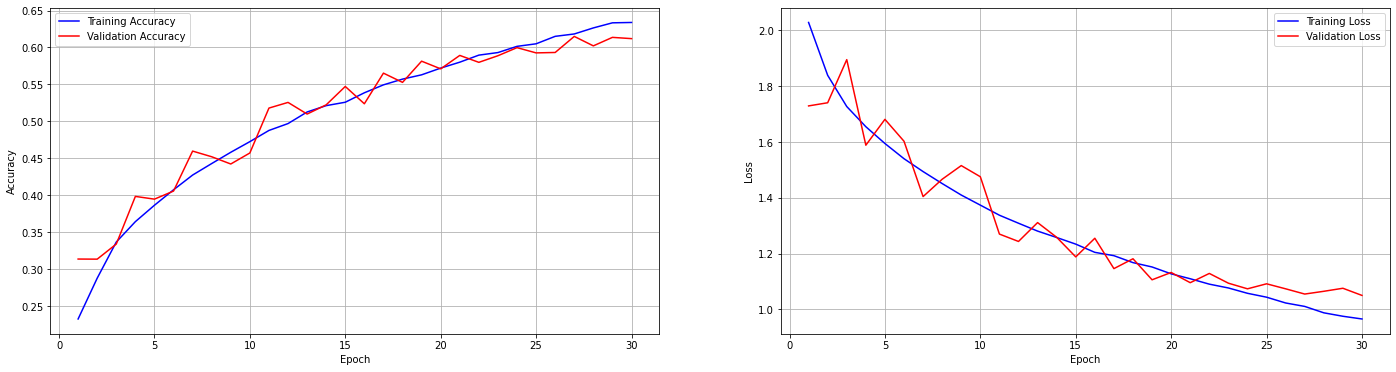

Best Validation Accuracy Score 0.61491, is for epoch 27
Best Training Accuracy Score 0.63381, is for epoch 30


In [13]:
plot_results(history)
get_best_epoch(history)

In [14]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

Plotting Confusion Matrix

Instructions for updating:
Please use Model.predict, which supports generators.


<Figure size 432x288 with 0 Axes>

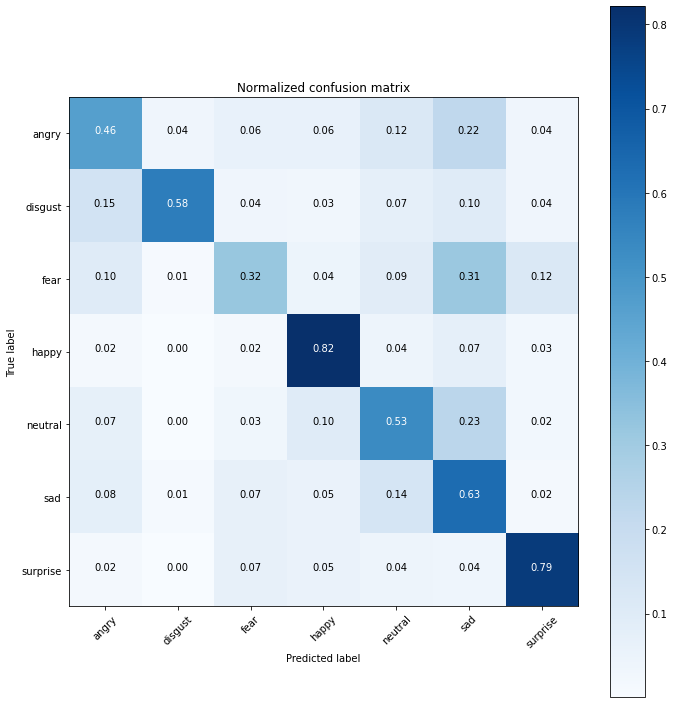

In [15]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict_generator(generator = validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()


def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, title='Normalized confusion matrix')
plt.show()

Predictions

In [12]:
import numpy as np
import cv2
from tensorflow.keras.models import model_from_json
import copy
import IPython

In [13]:
model_json_file = 'model.json'
model_weights_file = 'model_weights.h5'
with open(model_json_file, "r") as json_file:
    loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(model_weights_file)

In [53]:
import requests 

url = 'https://cainvas-static.s3.amazonaws.com/media/user_data/harshita_07/haarcascade_frontalface_default.xml'
resp = requests.get(url)

with open('haarcascade_frontalface_default.xml', 'wb') as f:
    f.write(resp.content)
    
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

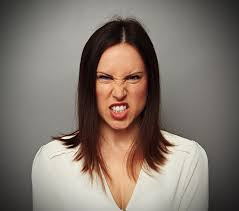

In [54]:
img = cv2.imread('angry.jpeg')
IPython.display.Image("angry.jpeg")

In [55]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
    fc = gray[y:y+h, x:x+w]
        
    roi = cv2.resize(fc, (48,48))
    pred = loaded_model.predict(roi[np.newaxis, :, :, np.newaxis])
    
    text_idx=np.argmax(pred)
    text_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
    
    if text_idx == 0:
        text= text_list[0]
    if text_idx == 1:
        text= text_list[1]
    elif text_idx == 2:
        text= text_list[2]
    elif text_idx == 3:
        text= text_list[3]
    elif text_idx == 4:
        text= text_list[4]
    elif text_idx == 5:
        text= text_list[5]
    elif text_idx == 6:
        text= text_list[6]
        
    cv2.putText(img, text, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 255), 2)
    img = cv2.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 2)

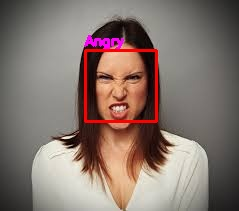

In [56]:
cv2.imwrite("output.jpg",img)
IPython.display.Image("output.jpg")

Compile Using DeepCC

In [11]:
!deepCC model_weights.h5

reading [keras model] from 'model_weights.h5'
Saved 'model_weights.onnx'
reading onnx model from file  model_weights.onnx
Model info:
  ir_vesion :  4 
  doc       : 
WARN (ONNX): graph-node conv2d's attribute auto_pad has no meaningful data.
WARN (ONNX): spatial is not a valid graph-node attribute.
             operator BatchNormalization will be added without this attribute.
WARN (ONNX): graph-node conv2d_1's attribute auto_pad has no meaningful data.
WARN (ONNX): spatial is not a valid graph-node attribute.
             operator BatchNormalization will be added without this attribute.
WARN (ONNX): graph-node conv2d_2's attribute auto_pad has no meaningful data.
WARN (ONNX): spatial is not a valid graph-node attribute.
             operator BatchNormalization will be added without this attribute.
WARN (ONNX): graph-node conv2d_3's attribute auto_pad has no meaningful data.
WARN (ONNX): spatial is not a valid graph-node attribute.
             operator BatchNormalization will be added